<a href="https://colab.research.google.com/github/taylorstallings/marketplace-funnel/blob/main/Marketplace_funnel_conversion_Taylor_Stallings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key Findings


*   Per-View Conversion Rate: 11.79%
* Search position 1 typically has the best conversion %, but positions 15-18 convert at the highest rate
* The listing with ID 142 converts at the highest % (23.86%)

*   **Funnel Conversion Rates:**
 * Search→View: 49.99%
 * View→Reserve: 36.85%
 * Reserve→Pay: 100.00%
 * Search→Pay: 18.42%




# Business Recommendations


Based on the observed drop-off point in the View to Reservation step in the conversion funnel, here are some recommendations:

1. **Refine the Search and Discovery Process**
* Run analysis on what search terms, filters, or time spent on page, to understand what users are doing.
* Set up an A/B test for different search page results based on user view history and user booking history.
* Identify reasons why the results in position 17 on average convert at such a high percentage


2. **Provide more information that can ease any concerns about the booking process to consumers.**

 * Include user reviews (blurbs or star ratings)

 * Provide more information about pricing

 * Provide information about availability of bookings

 * Include more of a call to action on the booking page

3. **Enhance user engagemnt on Listing Pages**

*  Recommend similar listings based on the page being viewed, or based on the prior viewing/purchase history of the user
*   Refine the search and discovery process. Search to view conversion is strong (50% conversion) compared to View to Reservation. Improve the process to ensure users are clicking on the pages that will help them convert to Pay




# Other Considerations and Next Steps

Because this analysis highlights clear drop-offs in the marketplace funnel, and in an effort to provide a better view of performance by user stage, search position, and listing, the following steps could be done to build on these findings:

* Segment analysis: Break down the funnel by geography, device type, or other user cohorts to see if conversion challenges are concentrated in certain groups.

* Temporal trends: Track funnel metrics week-over-week or month-over-month to identify whether recent product changes or seasonality affect performance.

* Listing-level diagnostics: Investigate high-view, low-conversion listings to spot patterns such as poor photos, incomplete descriptions, or pricing gaps.

* A/B testing: Use controlled experiments to test improvements to listing pages, search result layouts, or booking flow simplifications.

* User journey mapping: Explore multi-touch paths, and/or different paths taken by the same user at different times, to better understand decision cycles.

# Code and Visualizations

Setup & Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#for sql
try:
  import duckdb
except ImportError:
    %pip install duckdb -q
    import duckdb

#set up plotting and display defaults
pd.set_option("display.max_columns", None)
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (12, 8)
sns.set_palette("colorblind")

In [ ]:
# File paths
SEARCHES_CSV = "all_search_events.csv"
VIEWS_CSV = "view_listing_detail_events.csv"
RESERVATIONS_CSV = "reservations.csv"
USER_MAP_CSV = "amplitude_user_ids.csv"

def load_and_prepare_data():
    # Read with parsed dates to avoid piecemeal conversions later
    searches = pd.read_csv(
        SEARCHES_CSV,
        parse_dates=["event_time", "event_date"],
        dtype={"merged_amplitude_id": "string", "listing_id": "Int64"},
    )
    views = pd.read_csv(
        VIEWS_CSV,
        parse_dates=["event_time", "event_date"],
        dtype={"merged_amplitude_id": "string", "listing_id": "Int64", "search_position": "Int64"},
    )
    reservations = pd.read_csv(
        RESERVATIONS_CSV,
        parse_dates=["created_at", "approved_at", "successful_payment_collected_at"],
        dtype={"renter_user_id": "Int64", "listing_id": "Int64", "reservation_id": "Int64"},
    )
    user_mapping = pd.read_csv(
        USER_MAP_CSV,
        dtype={"user_id": "Int64", "merged_amplitude_id": "string"},
    )

    print("Loaded rows:",
          f"searches={len(searches):,}, views={len(views):,}, reservations={len(reservations):,}, user_mapping={len(user_mapping):,}")

    return {
        "searches": searches,
        "views": views,
        "reservations": reservations,
        "user_mapping": user_mapping,
    }

datasets = load_and_prepare_data()

Loaded rows: searches=100,000, views=88,633, reservations=10,363, user_mapping=10,000


In [ ]:
def normalize_and_flag(datasets):
    searches = datasets["searches"].copy()
    views = datasets["views"].copy()
    reservations = datasets["reservations"].copy()
    user_mapping = datasets["user_mapping"].copy()

    # map renter_user_id -> merged_amplitude_id for reservations
    user_to_amp = (
        user_mapping.dropna(subset=["user_id"])
        .set_index("user_id")["merged_amplitude_id"]
        .to_dict()
    )
    reservations["merged_amplitude_id"] = reservations["renter_user_id"].map(user_to_amp).astype("string")
    reservations["has_payment"] = reservations["successful_payment_collected_at"].notna()

    return {
        "searches": searches,
        "views": views,
        "reservations": reservations,
        "user_mapping": user_mapping,
    }

datasets = normalize_and_flag(datasets)


In [ ]:
def analyze_conversion_funnel(datasets):
    searches = datasets["searches"]
    views = datasets["views"]
    reservations = datasets["reservations"]

    # Unique users at stage (robust to empty)
    unique_searchers = max(searches["merged_amplitude_id"].nunique(), 0)
    unique_viewers = max(views["merged_amplitude_id"].nunique(), 0)
    unique_reservers = max(reservations["merged_amplitude_id"].dropna().nunique(), 0)
    unique_payers = max(reservations.loc[reservations["has_payment"], "merged_amplitude_id"].dropna().nunique(), 0)

    # Event-level counts
    total_searches = len(searches)
    total_views = len(views)
    total_reservations = len(reservations)
    total_payments = int(reservations["has_payment"].sum())

    funnel_df = pd.DataFrame({
        "stage": ["Search", "View", "Reserve", "Pay"],
        "unique_users": [unique_searchers, unique_viewers, unique_reservers, unique_payers],
        "total_events": [total_searches, total_views, total_reservations, total_payments],
    })

    if unique_searchers > 0 and total_searches > 0:
        funnel_df["user_conversion_rate"] = funnel_df["unique_users"] / unique_searchers * 100
        funnel_df["event_conversion_rate"] = funnel_df["total_events"] / total_searches * 100
    else:
        funnel_df["user_conversion_rate"] = 0.0
        funnel_df["event_conversion_rate"] = 0.0

    return funnel_df, {
        "searches": searches, "views": views, "reservations": reservations,
        "unique_searchers": unique_searchers, "unique_viewers": unique_viewers,
        "unique_reservers": unique_reservers, "unique_payers": unique_payers
    }

funnel_df, funnel_metrics = analyze_conversion_funnel(datasets)
print("Funnel summary:\n", funnel_df.to_string(index=False, float_format="%.1f"))


Funnel summary:
   stage  unique_users  total_events  user_conversion_rate  event_conversion_rate
 Search          7941        100000                 100.0                  100.0
   View          3970         88633                  50.0                   88.6
Reserve          1463         10363                  18.4                   10.4
    Pay          1463          9863                  18.4                    9.9


Register pandas DataFrames to DuckDB and validate counts

In [ ]:
con = duckdb.connect()
con.register("searches", datasets["searches"])
con.register("views", datasets["views"])
con.register("reservations", datasets["reservations"])

sql_funnel = """
WITH s AS (SELECT COUNT(DISTINCT merged_amplitude_id) AS unique_searchers FROM searches),
     v AS (SELECT COUNT(DISTINCT merged_amplitude_id) AS unique_viewers   FROM views),
     r AS (SELECT COUNT(DISTINCT merged_amplitude_id) AS unique_reservers FROM reservations WHERE merged_amplitude_id IS NOT NULL),
     p AS (SELECT COUNT(DISTINCT merged_amplitude_id) AS unique_payers    FROM reservations WHERE has_payment = TRUE AND merged_amplitude_id IS NOT NULL),
     es AS (SELECT COUNT(*) AS total_searches FROM searches),
     ev AS (SELECT COUNT(*) AS total_views FROM views),
     er AS (SELECT COUNT(*) AS total_reservations FROM reservations),
     ep AS (SELECT SUM(has_payment::INT) AS total_payments FROM reservations)
SELECT
  s.unique_searchers, v.unique_viewers, r.unique_reservers, p.unique_payers,
  es.total_searches, ev.total_views, er.total_reservations, ep.total_payments
FROM s, v, r, p, es, ev, er, ep;
"""

funnel_sql_check = con.execute(sql_funnel).df()
print("SQL funnel check:\n", funnel_sql_check)


SQL funnel check:
    unique_searchers  unique_viewers  unique_reservers  unique_payers  \
0              7941            3970              1463           1463   

   total_searches  total_views  total_reservations  total_payments  
0          100000        88633               10363          9863.0  


In [ ]:
def analyze_view_conversion_detailed(views, reservations):
    #merge on user and listing
    cols_keep = ["merged_amplitude_id", "listing_id", "created_at"]
    view_conversions = views.merge(reservations[cols_keep], on=["merged_amplitude_id", "listing_id"], how="left")

    #count conversion if reservation timestamp is present and after the view
    view_conversions["converted"] = view_conversions["created_at"].notna() & (
        view_conversions["created_at"] >= view_conversions["event_time"]
    )

    total_views = len(view_conversions)
    converted_views = int(view_conversions["converted"].sum())
    conv_rate = (converted_views / total_views * 100) if total_views else 0.0

    #if statement - by search position if column exists
    if "search_position" in view_conversions.columns:
        position_analysis = (
            view_conversions.groupby("search_position", dropna=False)
            .agg(total_views=("converted", "count"),
                 conversions=("converted", "sum"),
                 conversion_rate=("converted", "mean"))
            .reset_index()
        )
        position_analysis["conversion_rate"] *= 100
        #significance filter
        position_analysis = position_analysis.loc[position_analysis["total_views"] >= 100].copy()
    else:
        position_analysis = pd.DataFrame(columns=["search_position", "total_views", "conversions", "conversion_rate"])

    summary = {
        "total_views": total_views,
        "converted_views": converted_views,
        "view_to_reservation_rate_pct": round(conv_rate, 1),
        "drop_off_pct": round(100 - conv_rate, 1),
    }

    return view_conversions, position_analysis, summary

view_conversions, position_analysis, view_conv_summary = analyze_view_conversion_detailed(
    funnel_metrics["views"], funnel_metrics["reservations"]
)

print("View→Reservation summary:", view_conv_summary)
if not position_analysis.empty:
    print(position_analysis.head(10).to_string(index=False, float_format="%.1f"))
else:
    print("No sufficient search_position data to report.")


View→Reservation summary: {'total_views': 88701, 'converted_views': 10484, 'view_to_reservation_rate_pct': 11.8, 'drop_off_pct': 88.2}
 search_position  total_views  conversions  conversion_rate
               1         5305          669             12.6
               2         5190          604             11.6
               3         4917          538             10.9
               4         4689          557             11.9
               5         4727          511             10.8
               6         4581          526             11.5
               7         4440          519             11.7
               8         4466          550             12.3
               9         4358          505             11.6
              10         4305          493             11.5


view_conversions for validation

In [ ]:
con.register("view_conversions", view_conversions)

sql_pos = """
SELECT
  search_position,
  COUNT(*) AS total_views,
  SUM(CASE WHEN converted THEN 1 ELSE 0 END) AS conversions,
  100.0 * AVG(CASE WHEN converted THEN 1 ELSE 0 END) AS conversion_rate
FROM view_conversions
GROUP BY search_position
HAVING COUNT(*) >= 100
ORDER BY search_position
LIMIT 20;
"""

pos_sql_check = con.execute(sql_pos).df()
print("SQL position analysis check (first 20 rows):\n", pos_sql_check.head(20))


SQL position analysis check (first 20 rows):
     search_position  total_views  conversions  conversion_rate
0                 1         5305        669.0        12.610745
1                 2         5190        604.0        11.637765
2                 3         4917        538.0        10.941631
3                 4         4689        557.0        11.878865
4                 5         4727        511.0        10.810239
5                 6         4581        526.0        11.482209
6                 7         4440        519.0        11.689189
7                 8         4466        550.0        12.315271
8                 9         4358        505.0        11.587884
9                10         4305        493.0        11.451800
10               11         4305        497.0        11.544715
11               12         4308        530.0        12.302693
12               13         4245        497.0        11.707892
13               14         4101        474.0        11.558157
14       

In [ ]:
def analyze_user_behavior(funnel_metrics):
    searches = funnel_metrics["searches"]
    views = funnel_metrics["views"]
    reservations = funnel_metrics["reservations"]

    search_behavior = searches.groupby("merged_amplitude_id").size().to_frame("search_count")
    view_behavior = views.groupby("merged_amplitude_id").size().to_frame("view_count")
    reservation_behavior = (
        reservations.groupby("merged_amplitude_id")
        .agg(reservation_count=("reservation_id", "count"),
             payment_count=("has_payment", "sum"))
    )

    user_behavior = search_behavior.join(view_behavior, how="outer").join(reservation_behavior, how="outer")
    user_behavior = user_behavior.fillna(0)
    user_behavior["converted_to_payment"] = user_behavior["payment_count"] > 0

    behavior_comparison = (
        user_behavior.groupby("converted_to_payment")[["search_count","view_count","reservation_count"]]
        .agg(["mean", "median"])
        .round(1)
    )

    return user_behavior, behavior_comparison

user_behavior, behavior_comparison = analyze_user_behavior(funnel_metrics)
print("Behavior comparison (non-converters vs converters):\n", behavior_comparison)


Behavior comparison (non-converters vs converters):
                      search_count        view_count        reservation_count  \
                             mean median       mean median              mean   
converted_to_payment                                                           
False                        12.6   12.0        8.6    0.0               0.0   
True                         12.7   12.0       22.7   22.0               7.1   

                             
                     median  
converted_to_payment         
False                   0.0  
True                    7.0  


# Deeper Analysis

View-level merge

In [ ]:
views = funnel_metrics["views"]
reservations = funnel_metrics["reservations"]
searches = funnel_metrics["searches"]

tmp = views.merge(
    reservations[["merged_amplitude_id", "listing_id", "reservation_id", "created_at"]],
    on=["merged_amplitude_id", "listing_id"],
    how="left"
)

tmp["converted_flag"] = (
    tmp["created_at"].notna() & (tmp["created_at"] >= tmp["event_time"])
)

view_conv = (
    tmp.groupby(["merged_amplitude_id", "listing_id", "event_time", "search_position"], dropna=False)
       .agg(converted_to_reservation=("converted_flag", "max"))
       .reset_index()
)

# 4) Sanity checks — null IDs
null_searches = searches["merged_amplitude_id"].isna().mean() * 100
null_views = views["merged_amplitude_id"].isna().mean() * 100
print(f"\nNull user IDs: searches={null_searches:.2f}%, views={null_views:.2f}%")

# 5) Search position performance
pos_stats = (
    view_conv.groupby("search_position", dropna=False)
             .agg(views=("event_time", "count"),
                  conversions=("converted_to_reservation", "sum"))
             .reset_index()
)
pos_stats["conv_pct"] = np.where(pos_stats["views"] > 0,
                                 pos_stats["conversions"] / pos_stats["views"] * 100, np.nan)
pos_stats = pos_stats.sort_values("search_position")
print("\nSearch position stats (first 10 rows):")
print(pos_stats.head(10).to_string(index=False, float_format="%.2f"))

# 6) Listing performance (min 10 views)
listing_perf = (
    view_conv.groupby("listing_id", dropna=False)
             .agg(views=("event_time", "count"),
                  conversions=("converted_to_reservation", "sum"))
             .reset_index()
)
listing_perf["conv_pct"] = np.where(listing_perf["views"] > 0,
                                    listing_perf["conversions"] / listing_perf["views"] * 100, np.nan)
listing_perf = listing_perf[listing_perf["views"] >= 10].sort_values("conv_pct", ascending=False)
print("\nTop listings (min 10 views):")
print(listing_perf.head(10).to_string(index=False, float_format="%.2f"))

# Optionally keep these around for plotting
extra_metrics = {
    "view_conv": view_conv,
    "pos_stats": pos_stats,
    "listing_perf": listing_perf,
    "user_rates": rates,
    "funnel_counts_users": funnel_counts,
}


Per-view conversion rate: 11.79% (10,450 / 88,633)

User funnel counts: {'searchers': 7941, 'viewers': 3970, 'reservers': 1463, 'payers': 1463}
Conversion rates (unique users, %):
 Search→View: 49.99%
 View→Reserve: 36.85%
 Reserve→Pay: 100.00%
 Search→Pay: 18.42%

Null user IDs: searches=0.00%, views=0.00%

Search position stats (first 10 rows):
 search_position  views  conversions  conv_pct
               1   5300          668     12.60
               2   5183          599     11.56
               3   4913          537     10.93
               4   4681          554     11.84
               5   4724          509     10.77
               6   4579          524     11.44
               7   4438          518     11.67
               8   4461          547     12.26
               9   4357          505     11.59
              10   4301          489     11.37

Top listings (min 10 views):
 listing_id  views  conversions  conv_pct
        142     88           21     23.86
         87     85  

per-view metrics

In [ ]:

total_views = len(view_conv)
converted_views = int(view_conv["converted_to_reservation"].sum())
view_to_reservation_rate = (converted_views / total_views * 100) if total_views else np.nan
print(f"Per-view conversion rate: {view_to_reservation_rate:.2f}% ({converted_views:,} / {total_views:,})")


Per-view conversion rate: 11.79% (10,450 / 88,633)


User-level funnel (unique users by stage)

In [ ]:
users_search  = set(searches["merged_amplitude_id"].dropna())
users_view    = set(views["merged_amplitude_id"].dropna())
users_reserve = set(reservations["merged_amplitude_id"].dropna())
users_pay     = set(
    reservations.loc[reservations["successful_payment_collected_at"].notna(), "merged_amplitude_id"].dropna()
)

funnel_counts = {
    "searchers": len(users_search),
    "viewers": len(users_view),
    "reservers": len(users_reserve),
    "payers": len(users_pay),
}
rates = {
    "Search→View":   (len(users_view)    / len(users_search)  * 100) if users_search  else np.nan,
    "View→Reserve":  (len(users_reserve) / len(users_view)    * 100) if users_view    else np.nan,
    "Reserve→Pay":   (len(users_pay)     / len(users_reserve) * 100) if users_reserve else np.nan,
    "Search→Pay":    (len(users_pay)     / len(users_search)  * 100) if users_search  else np.nan,
}

print("\nUser funnel counts:", funnel_counts)
print("Conversion rates (unique users, %):")
for k in ["Search→View","View→Reserve","Reserve→Pay","Search→Pay"]:
    v = rates[k]
    print(f" {k}: {v:.2f}%")


User funnel counts: {'searchers': 7941, 'viewers': 3970, 'reservers': 1463, 'payers': 1463}
Conversion rates (unique users, %):
 Search→View: 49.99%
 View→Reserve: 36.85%
 Reserve→Pay: 100.00%
 Search→Pay: 18.42%


Sanity Checks

In [ ]:
null_searches = searches["merged_amplitude_id"].isna().mean() * 100
null_views = views["merged_amplitude_id"].isna().mean() * 100
print(f"\nNull user IDs: searches={null_searches:.2f}%, views={null_views:.2f}%")



Null user IDs: searches=0.00%, views=0.00%


Performance by Search Position

In [ ]:
pos_stats = (
    view_conv.groupby("search_position", dropna=False)
             .agg(views=("event_time", "count"),
                  conversions=("converted_to_reservation", "sum"))
             .reset_index()
)
pos_stats["conv_pct"] = np.where(pos_stats["views"] > 0,
                                 pos_stats["conversions"] / pos_stats["views"] * 100, np.nan)
pos_stats = pos_stats.sort_values("search_position")
print("\nSearch position stats (first 10 rows):")
print(pos_stats.head(10).to_string(index=False, float_format="%.2f"))


Search position stats (first 10 rows):
 search_position  views  conversions  conv_pct
               1   5300          668     12.60
               2   5183          599     11.56
               3   4913          537     10.93
               4   4681          554     11.84
               5   4724          509     10.77
               6   4579          524     11.44
               7   4438          518     11.67
               8   4461          547     12.26
               9   4357          505     11.59
              10   4301          489     11.37


Listing Performance

In [ ]:
listing_perf = (
    view_conv.groupby("listing_id", dropna=False)
             .agg(views=("event_time", "count"),
                  conversions=("converted_to_reservation", "sum"))
             .reset_index()
)
listing_perf["conv_pct"] = np.where(listing_perf["views"] > 0,
                                    listing_perf["conversions"] / listing_perf["views"] * 100, np.nan)
listing_perf = listing_perf[listing_perf["views"] >= 10].sort_values("conv_pct", ascending=False)
print("\nTop listings (min 10 views):")
print(listing_perf.head(10).to_string(index=False, float_format="%.2f"))



Top listings (min 10 views):
 listing_id  views  conversions  conv_pct
        142     88           21     23.86
         87     85           20     23.53
        141     77           18     23.38
        453     86           20     23.26
        564     69           16     23.19
        852     90           20     22.22
        896     70           15     21.43
        291     85           18     21.18
        857    109           23     21.10
         15     96           20     20.83


# Visualizations

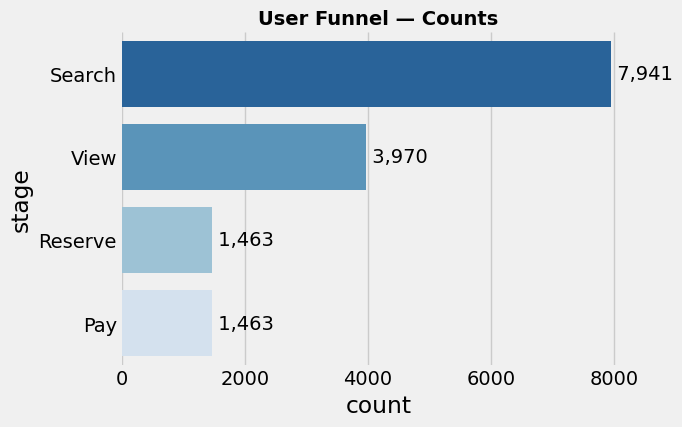

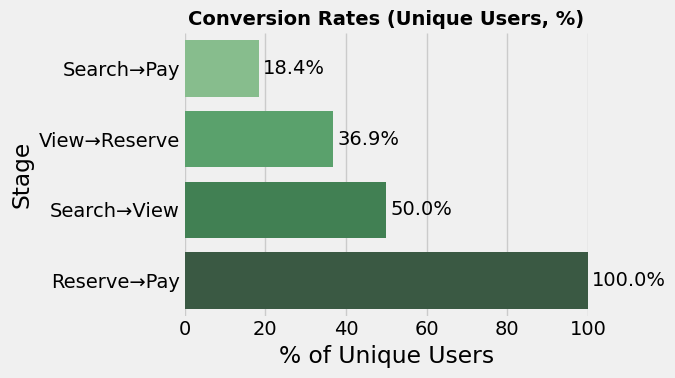

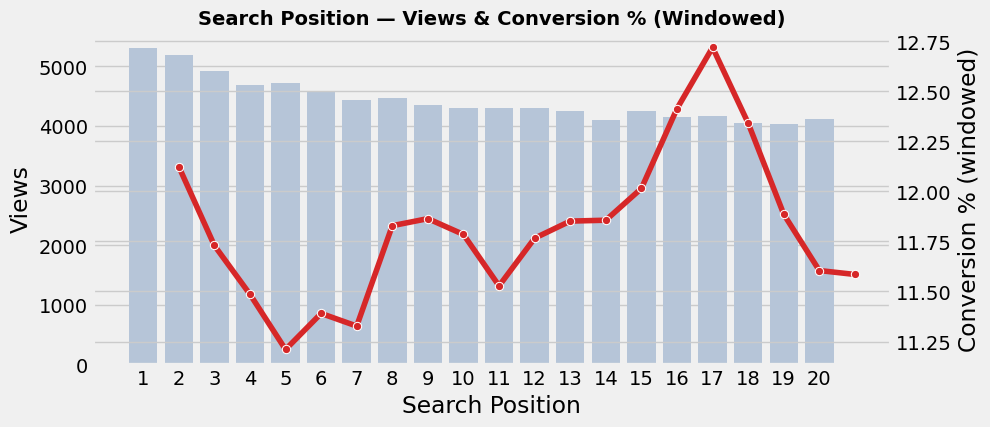

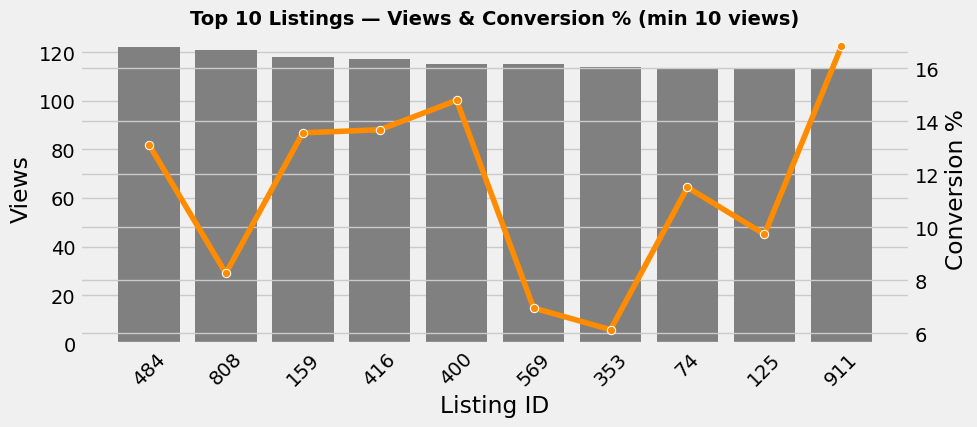

In [ ]:
def create_funnel_visualizations(funnel_df, view_conversions, position_analysis):
    funnel_counts = dict(zip(funnel_df["stage"], funnel_df["unique_users"]))

    #step and overall conversion
    rates = {}
    for i in range(len(funnel_df) - 1):
        denom = funnel_df.iloc[i]["unique_users"]
        numer = funnel_df.iloc[i+1]["unique_users"]
        rates[f'{funnel_df.iloc[i]["stage"]}→{funnel_df.iloc[i+1]["stage"]}'] = (numer / denom * 100) if denom else 0.0
    rates["Search→Pay"] = (funnel_df.iloc[-1]["unique_users"] / funnel_df.iloc[0]["unique_users"] * 100) if funnel_df.iloc[0]["unique_users"] else 0.0

    # Viz 1 - Funnel counts
    fig, ax = plt.subplots(figsize=(7, 4.5))
    fdf = pd.DataFrame({"stage": ["Search","View","Reserve","Pay"], "count": [funnel_counts.get(s,0) for s in ["Search","View","Reserve","Pay"]]})
    sns.barplot(data=fdf, y="stage", x="count", ax=ax, palette="Blues_r")
    ax.set_title("User Funnel — Counts", fontsize=14, fontweight="bold")
    for i, r in enumerate(fdf.itertuples()):
        ax.text(r.count, i, f" {int(r.count):,}", va="center")
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

    # Viz 2 - Conversion rates
    fig, ax = plt.subplots(figsize=(7, 4))
    rates_ser = pd.Series(rates).sort_values()
    sns.barplot(x=rates_ser.values, y=rates_ser.index, ax=ax, palette="Greens_d")
    ax.set_title("Conversion Rates (Unique Users, %)", fontsize=14, fontweight="bold")
    for i, v in enumerate(rates_ser.values):
        ax.text(v + (0.01 * max(1, rates_ser.values.max())), i, f"{v:.1f}%", va="center")
    ax.set_xlim(0, 100)
    ax.set_xlabel("% of Unique Users")
    ax.set_ylabel("Stage")
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

    # Viz 3 - Position analysis
    if not position_analysis.empty:
        pos_stats = position_analysis.rename(columns={"conversion_rate": "conv_pct"}).copy()
        pos_stats = pos_stats.sort_values("search_position")
        pos_stats["conv_pct_win"] = pos_stats["conv_pct"].rolling(window=3, center=True, min_periods=1).mean()

        fig, ax1 = plt.subplots(figsize=(10, 4.5))
        sns.barplot(data=pos_stats, x="search_position", y="total_views", color="lightsteelblue", ax=ax1)
        ax1.set_ylabel("Views")
        ax1.set_xlabel("Search Position")
        ax1.set_title("Search Position — Views & Conversion % (Windowed)", fontsize=14, fontweight="bold")

        ax2 = ax1.twinx()
        sns.lineplot(data=pos_stats, x="search_position", y="conv_pct_win", marker="o", ax=ax2, color="tab:red")
        ax2.set_ylabel("Conversion % (windowed)")
        plt.tight_layout()
        plt.show()

    # Viz 4 - Listing performance
    listing_perf = (
        view_conversions.groupby("listing_id")
        .agg(views=("converted", "count"),
             conversions=("converted", "sum"),
             conv_pct=("converted", "mean"))
        .reset_index()
    )
    listing_perf["conv_pct"] = listing_perf["conv_pct"] * 100
    listing_perf = listing_perf.loc[listing_perf["views"] >= 10].sort_values("views", ascending=False)

    topN = 10
    top_list = listing_perf.head(topN).copy()
    if not top_list.empty:
        fig, ax1 = plt.subplots(figsize=(10, 4.5))
        sns.barplot(data=top_list, x=top_list["listing_id"].astype(str), y="views", color="gray", ax=ax1)
        ax1.set_ylabel("Views")
        ax1.set_xlabel("Listing ID")
        ax1.set_title(f"Top {topN} Listings — Views & Conversion % (min 10 views)", fontsize=14, fontweight="bold")
        ax1.tick_params(axis="x", rotation=45)

        ax2 = ax1.twinx()
        sns.lineplot(data=top_list, x=top_list["listing_id"].astype(str), y="conv_pct", marker="o", ax=ax2, color="darkorange")
        ax2.set_ylabel("Conversion %")
        plt.tight_layout()
        plt.show()

    return {"funnel_counts": funnel_counts, "conversion_rates": rates, "listing_performance": listing_perf}

viz_objs = create_funnel_visualizations(funnel_df, view_conversions, position_analysis)
